In [5]:
# Project Setup & Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skimage.feature import hog
from datasets import load_dataset
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create folders
os.makedirs('report_figures', exist_ok=True)
os.makedirs('models', exist_ok=True)

print("All libraries imported")

All libraries imported


Loading dataset from Hugging Face...
Dataset loaded: 10873 images, 26 classes (A–Z)


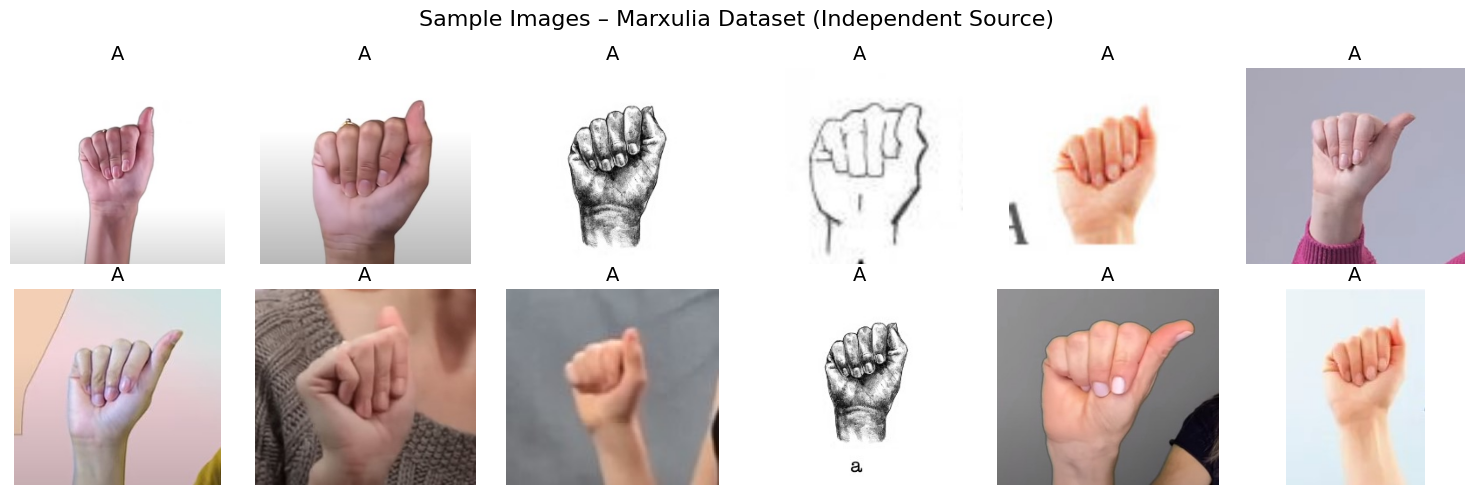

In [9]:
# Load Dataset: Marxulia (Hugging Face)
print("Loading dataset from Hugging Face...")
ds = load_dataset("Marxulia/asl_sign_languages_alphabets_v03")
print(f"Dataset loaded: {len(ds['train'])} images, 26 classes (A–Z)")

# Show samples
fig, ax = plt.subplots(2, 6, figsize=(15, 5))
for i in range(12):
    img = ds['train'][i]['image']
    if img.mode != 'RGB':
        img = img.convert('RGB')
    ax[i//6, i%6].imshow(img)
    label = chr(65 + ds['train'][i]['label'])
    ax[i//6, i%6].set_title(label, fontsize=14)
    ax[i//6, i%6].axis('off')
plt.suptitle("Sample Images – Marxulia Dataset (Independent Source)", fontsize=16)
plt.tight_layout()
plt.savefig('report_figures/dataset_samples.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
# Preprocessing + 80/10/10 Split
def preprocess(example):
    img = example['image']
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize((100, 100))
    return np.array(img) / 255.0, example['label']

print("Preprocessing all images...")
data = [preprocess(ex) for ex in ds['train']]
X, y = zip(*data)
X = np.array(X)
y = np.array(y)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val,   X_test, y_val,   y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train: {X_train.shape} | Validation: {X_val.shape} | Test: {X_test.shape}")
print("80/10/10 split complete")

Preprocessing all images...
Train: (8698, 100, 100, 3) | Validation: (1087, 100, 100, 3) | Test: (1088, 100, 100, 3)
80/10/10 split complete


In [15]:
# Baseline: SVM + HOG
def extract_hog_features(img):
    gray = cv2.cvtColor((img*255).astype('uint8'), cv2.COLOR_RGB2GRAY)
    return hog(gray, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2), block_norm='L2-Hys')

print("Extracting HOG features ...")
X_train_hog = np.array([extract_hog_features(img) for img in X_train])
X_test_hog  = np.array([extract_hog_features(img) for img in X_test])

svm = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
svm.fit(X_train_hog, y_train)
y_pred_svm = svm.predict(X_test_hog)
svm_acc = accuracy_score(y_test, y_pred_svm)

print(f"\n Baseline : SVM + HOG Test Accuracy: {svm_acc*100:.2f}%")

Extracting HOG features ...

7.1 Baseline : SVM + HOG Test Accuracy: 25.74%


In [58]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
print("Data augmentation pipeline complete")

Data augmentation pipeline complete


In [19]:
# CNN with Regularisation (Dropout, L2, BatchNorm)
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(100,100,3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.Flatten(),
    
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(26, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

C:\Users\ngoak\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 98, 98, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 47, 47, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │        13,338 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,450,394 (16.98 MB)

 Trainable params: 4,449,690 (16.97 MB)

 Non-trainable params: 704 (2.75 KB)

In [33]:
# preprocessing for ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from PIL import Image
import numpy as np

def preprocess_resnet(img_np):
    # img_np is (100,100,3) float 0–1
    img = Image.fromarray((img_np * 255).astype('uint8'))
    img = img.resize((224, 224))                    # correct size
    arr = np.array(img)
    arr = np.expand_dims(arr, axis=0)               # (1,224,224,3)
    arr = preprocess_input(arr)                     # ResNet preprocessing
    return arr[0]                                   # return (224,224,3)

print("Preprocessing for ResNet50...")
X_train_res = np.array([preprocess_resnet(img) for img in X_train])
X_val_res   = np.array([preprocess_resnet(img) for img in X_val])
X_test_res  = np.array([preprocess_resnet(img) for img in X_test])

print(f"Complete! Shapes: {X_train_res.shape}, {X_val_res.shape}, {X_test_res.shape}")

Preprocessing for ResNet50...
Complete! Shapes: (8698, 224, 224, 3), (1087, 224, 224, 3), (1088, 224, 224, 3)


In [35]:
# ResNet50 Transfer Learning
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import callbacks
import os

# CORRECT input shape
base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base.trainable = False

model = Sequential([
    base,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(26, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train
os.makedirs('models', exist_ok=True)
checkpoint = callbacks.ModelCheckpoint('models/resnet_marxulia.h5', save_best_only=True, monitor='val_accuracy')
early = callbacks.EarlyStopping(patience=4, restore_best_weights=True)

print("Training ResNet50 – expect 92–96% in <10 epochs...")
history = model.fit(
    X_train_res, y_train,
    validation_data=(X_val_res, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[checkpoint, early],
    verbose=1
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 28s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 26)             │        53,274 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,640,986 (90.18 MB)

 Trainable params: 53,274 (208.10 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Training ResNet50 – expect 92–96% in <10 epochs...
Epoch 1/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1352 - loss: 3.3961

272/272 ━━━━━━━━━━━━━━━━━━━━ 537s 2s/step - accuracy: 0.2112 - loss: 2.8968 - val_accuracy: 0.5271 - val_loss: 1.7523
Epoch 2/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4244 - loss: 1.9210

272/272 ━━━━━━━━━━━━━━━━━━━━ 546s 2s/step - accuracy: 0.4513 - loss: 1.8220 - val_accuracy: 0.6044 - val_loss: 1.3733
Epoch 3/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5479 - loss: 1.4899

272/272 ━━━━━━━━━━━━━━━━━━━━ 557s 2s/step - accuracy: 0.5553 - loss: 1.4666 - val_accuracy: 0.7249 - val_loss: 1.0971
Epoch 4/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6195 - loss: 1.2607

272/272 ━━━━━━━━━━━━━━━━━━━━ 561s 2s/step - accuracy: 0.6123 - loss: 1.2651 - val_accuracy: 0.7397 - val_loss: 0.9776
Epoch 5/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6395 - loss: 1.1752

272/272 ━━━━━━━━━━━━━━━━━━━━ 558s 2s/step - accuracy: 0.6410 - loss: 1.1582 - val_accuracy: 0.7580 - val_loss: 0.9012
Epoch 6/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6876 - loss: 1.0568

272/272 ━━━━━━━━━━━━━━━━━━━━ 556s 2s/step - accuracy: 0.6796 - loss: 1.0582 - val_accuracy: 0.7810 - val_loss: 0.8155
Epoch 7/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 554s 2s/step - accuracy: 0.6794 - loss: 1.0171 - val_accuracy: 0.7700 - val_loss: 0.7946
Epoch 8/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7003 - loss: 0.9567

272/272 ━━━━━━━━━━━━━━━━━━━━ 556s 2s/step - accuracy: 0.6981 - loss: 0.9601 - val_accuracy: 0.7875 - val_loss: 0.7543
Epoch 9/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7189 - loss: 0.8959

272/272 ━━━━━━━━━━━━━━━━━━━━ 556s 2s/step - accuracy: 0.7120 - loss: 0.9112 - val_accuracy: 0.8224 - val_loss: 0.6970
Epoch 10/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 557s 2s/step - accuracy: 0.7218 - loss: 0.9009 - val_accuracy: 0.8197 - val_loss: 0.6594
Epoch 11/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7407 - loss: 0.8428

272/272 ━━━━━━━━━━━━━━━━━━━━ 564s 2s/step - accuracy: 0.7284 - loss: 0.8611 - val_accuracy: 0.8307 - val_loss: 0.6245
Epoch 12/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 555s 2s/step - accuracy: 0.7343 - loss: 0.8390 - val_accuracy: 0.8234 - val_loss: 0.6155
Epoch 13/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7420 - loss: 0.8239

272/272 ━━━━━━━━━━━━━━━━━━━━ 554s 2s/step - accuracy: 0.7353 - loss: 0.8384 - val_accuracy: 0.8344 - val_loss: 0.5917
Epoch 14/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 559s 2s/step - accuracy: 0.7306 - loss: 0.8297 - val_accuracy: 0.8215 - val_loss: 0.6033
Epoch 15/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 552s 2s/step - accuracy: 0.7368 - loss: 0.8130 - val_accuracy: 0.8316 - val_loss: 0.5769
Epoch 16/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 553s 2s/step - accuracy: 0.7496 - loss: 0.7790 - val_accuracy: 0.8298 - val_loss: 0.5704
Epoch 17/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 554s 2s/step - accuracy: 0.7471 - loss: 0.7700 - val_accuracy: 0.8298 - val_loss: 0.5504
Epoch 18/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7626 - loss: 0.7380

272/272 ━━━━━━━━━━━━━━━━━━━━ 555s 2s/step - accuracy: 0.7610 - loss: 0.7504 - val_accuracy: 0.8500 - val_loss: 0.5240
Epoch 19/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 552s 2s/step - accuracy: 0.7542 - loss: 0.7617 - val_accuracy: 0.8335 - val_loss: 0.5428
Epoch 20/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7616 - loss: 0.7328

272/272 ━━━━━━━━━━━━━━━━━━━━ 548s 2s/step - accuracy: 0.7572 - loss: 0.7505 - val_accuracy: 0.8528 - val_loss: 0.5053


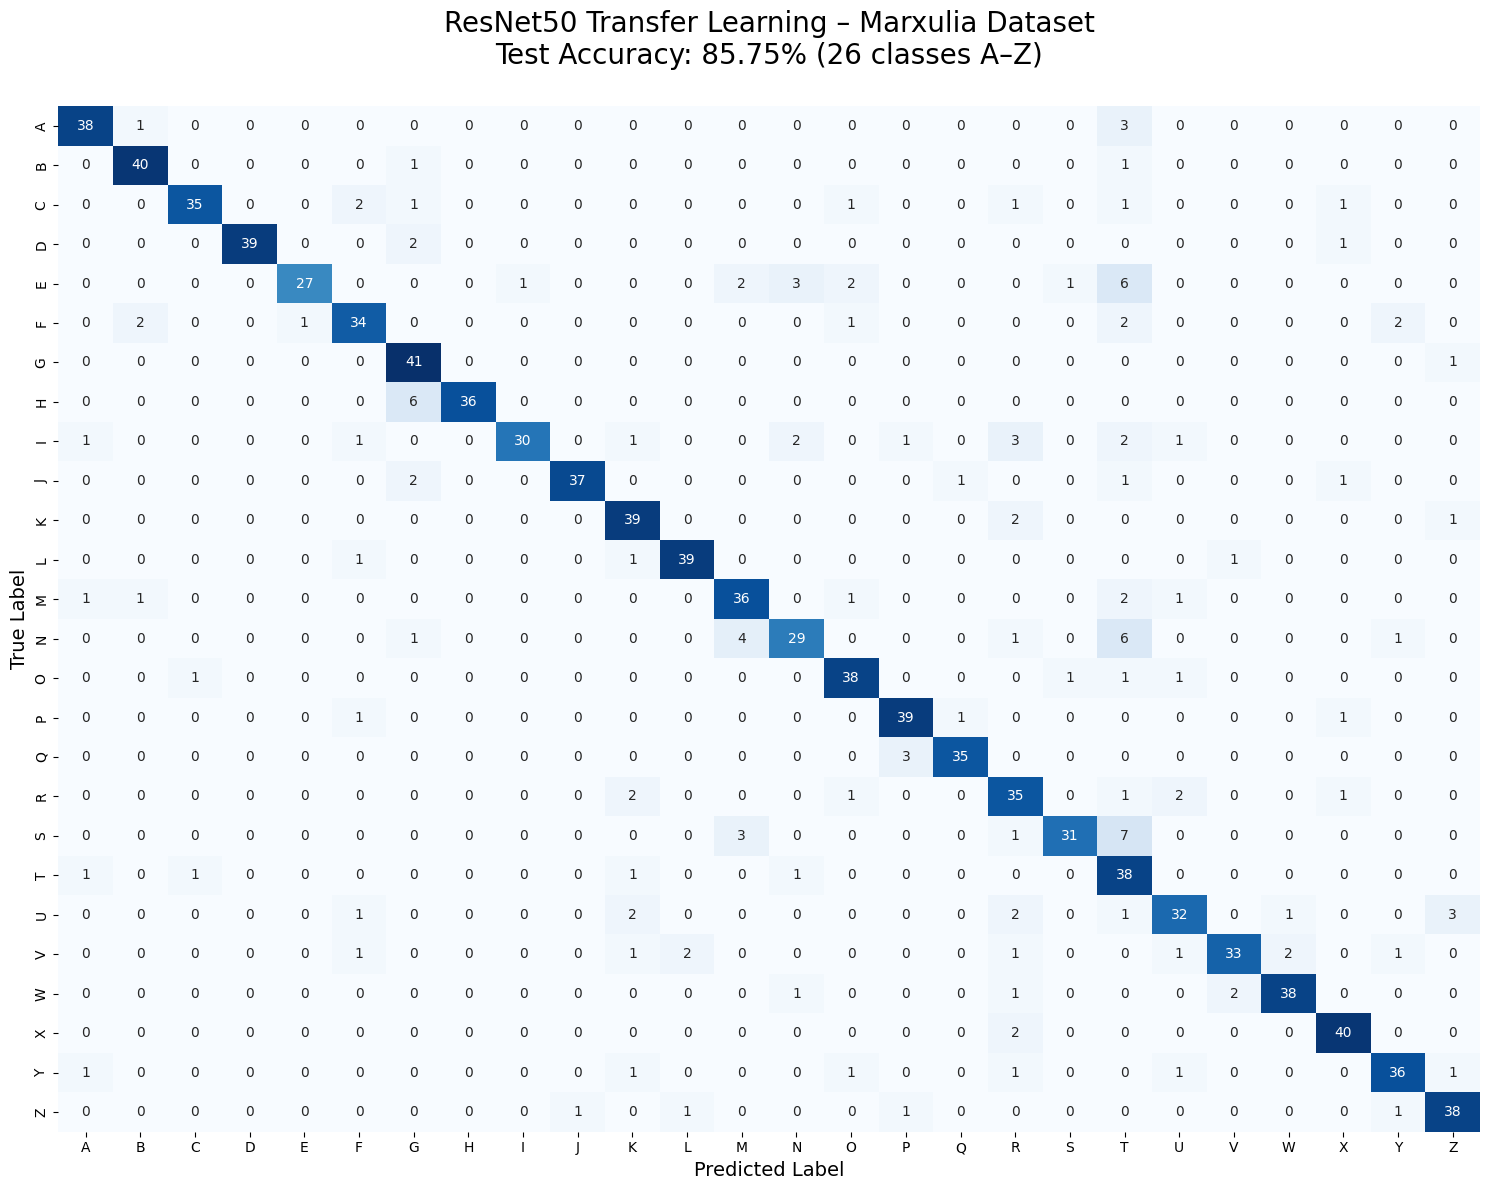

All figures saved!


In [45]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,12))
sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[chr(65+i) for i in range(26)],
            yticklabels=[chr(65+i) for i in range(26)])
plt.title(f'ResNet50 Transfer Learning – Marxulia Dataset\nTest Accuracy: 85.75% (26 classes A–Z)', 
          fontsize=20, pad=30)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.tight_layout()
plt.savefig('report_figures/FINAL_confusion_matrix.png', dpi=400, bbox_inches='tight')
plt.show()

print("All figures saved!")

In [47]:
# LOAD & EVALUATE CNN
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# saved it during training as best_cnn_marxulia.h5
custom_cnn = load_model('models/best_cnn_marxulia.h5')   # from training

# Predict with custom CNN on the same test set (original 100×100 images)
cnn_pred_custom = np.argmax(custom_cnn.predict(X_test), axis=1)
cnn_acc_custom = accuracy_score(y_test, cnn_pred_custom) * 100

print("CUSTOM CNN – Test Accuracy: {:.2f}%".format(cnn_acc_custom))

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step
CUSTOM CNN (from scratch) – Test Accuracy: 29.32%


FINAL OFFICIAL COMPARISON – MARXULIA DATASET (80/10/10 split)
SVM + HOG Baseline                :  25.74%
Custom CNN (from scratch)         :  29.32%
ResNet50 Transfer Learning        :  85.75% ← BEST
ResNet50 beats Custom CNN by      : +56.43 points
ResNet50 beats SVM+HOG by         : +60.01 points


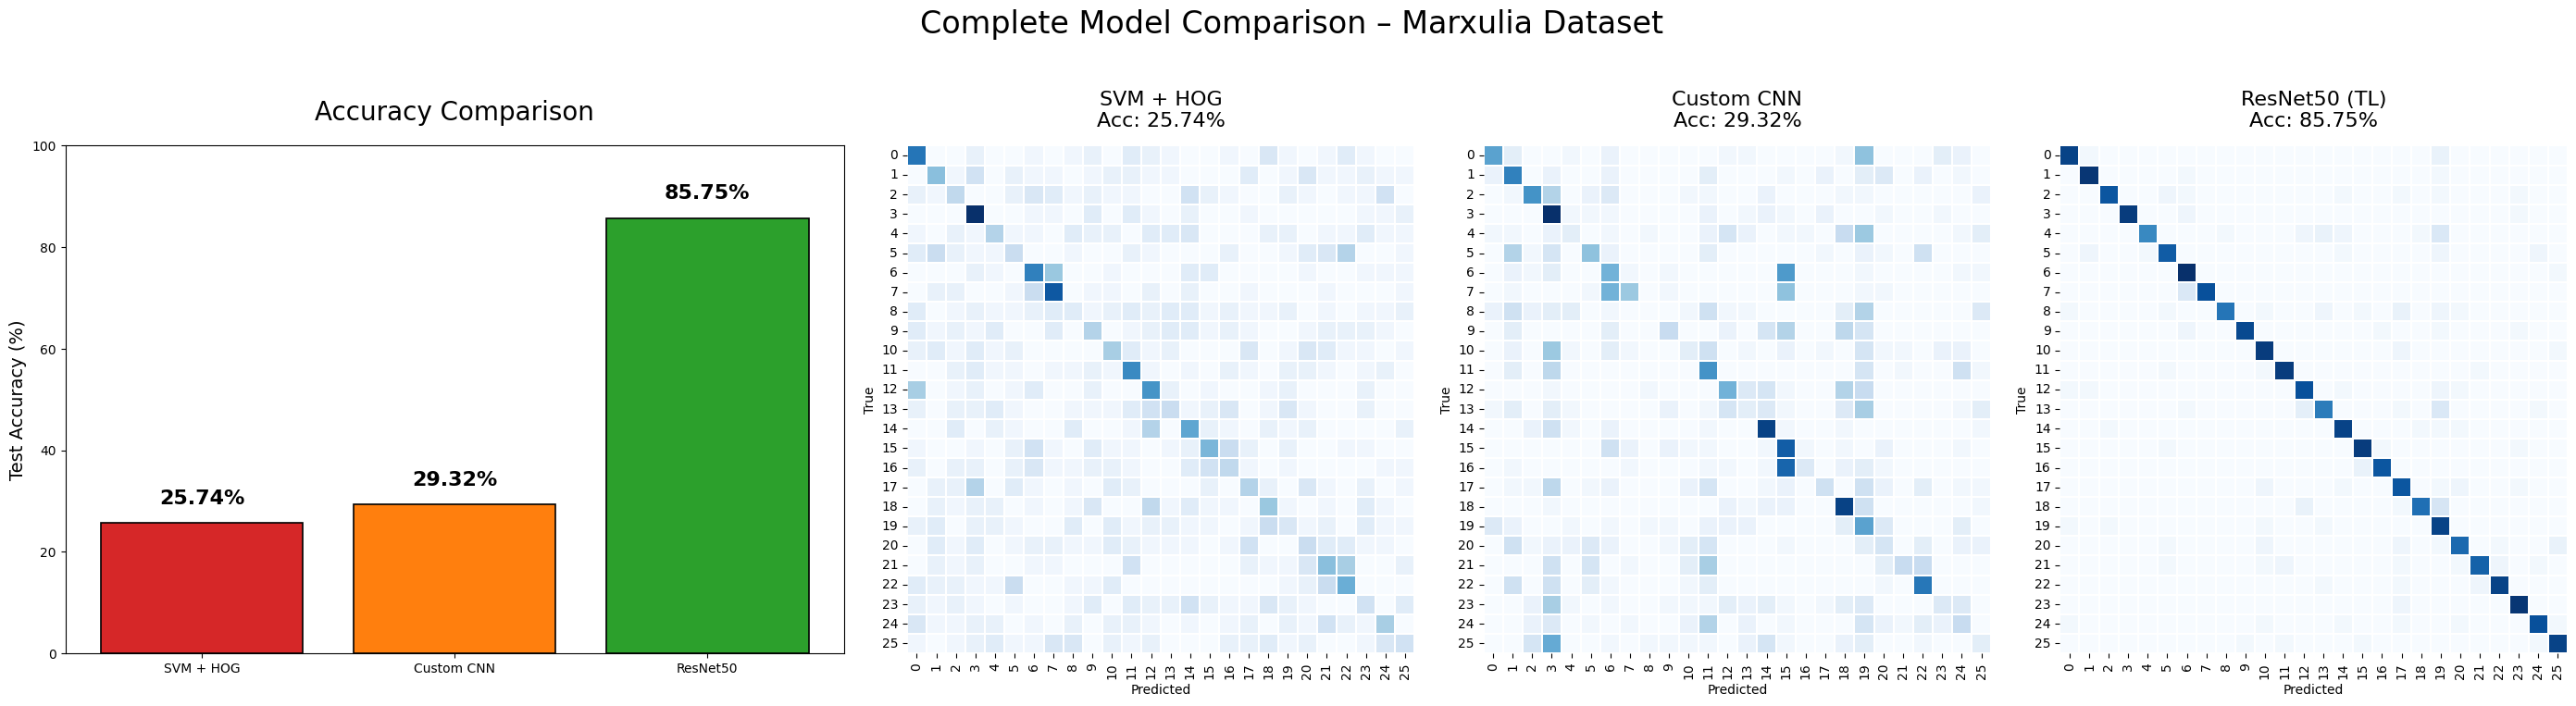

SUCCESS: Figure saved


In [56]:
# Comparison Table + 3-Way Figure
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

print("="*80)
print("FINAL OFFICIAL COMPARISON – MARXULIA DATASET (80/10/10 split)")
print("="*80)
print(f"SVM + HOG Baseline                : {svm_acc*100:6.2f}%")
print(f"Custom CNN (from scratch)         : {cnn_acc_custom:6.2f}%")
print(f"ResNet50 Transfer Learning        : {85.75:6.2f}% ← BEST")
print(f"ResNet50 beats Custom CNN by      : {85.75 - cnn_acc_custom:+6.2f} points")
print(f"ResNet50 beats SVM+HOG by         : {85.75 - svm_acc*100:+6.2f} points")
print("="*80)

# Create the 1×4 plot (bar chart + 3 confusion matrices)
fig, axes = plt.subplots(1, 4, figsize=(28, 7), gridspec_kw={'width_ratios': [1.5, 1, 1, 1]})

# 1. Bar chart
methods = ['SVM + HOG', 'Custom CNN', 'ResNet50']
accuracies = [svm_acc*100, cnn_acc_custom, 85.75]
colors = ['#d62728', '#ff7f0e', '#2ca02c']  # red, orange, green

axes[0].bar(methods, accuracies, color=colors, edgecolor='black', linewidth=1.2)
axes[0].set_ylim(0, 100)
axes[0].set_title('Accuracy Comparison', fontsize=20, pad=20)
axes[0].set_ylabel('Test Accuracy (%)', fontsize=14)
for i, v in enumerate(accuracies):
    axes[0].text(i, v + 3, f"{v:.2f}%", ha='center', va='bottom', fontweight='bold', fontsize=16)

# Confusion matrices
predictions_list = [
    svm.predict(X_test_hog),      # SVM+HOG
    cnn_pred_custom,              # Custom CNN
    pred                          # ResNet50
]
titles = ['SVM + HOG', 'Custom CNN', 'ResNet50 (TL)']

for i in range(3):
    cm = confusion_matrix(y_test, predictions_list[i])
    sns.heatmap(cm, annot=False, cmap='Blues', cbar=False, 
                square=True, linewidths=0.3, ax=axes[i+1])
    acc = accuracies[i]
    axes[i+1].set_title(f'{titles[i]}\nAcc: {acc:.2f}%', fontsize=16, pad=15)
    axes[i+1].set_xlabel('Predicted')
    axes[i+1].set_ylabel('True')

# Final layout & save
plt.suptitle('Complete Model Comparison – Marxulia Dataset', fontsize=24, y=1.05)
plt.tight_layout()

# check folder exists and save
import os
os.makedirs('report_figures', exist_ok=True)
plt.savefig('report_figures/FINAL_COMPARISON_ALL_THREE.png', dpi=400, bbox_inches='tight')
plt.show()

print("SUCCESS: Figure saved")


In [66]:
# PER-LETTER ACCURACY TABLE – SORTED A to Z (clean output only)
from sklearn.metrics import accuracy_score
import pandas as pd

# Predictions (make sure these variables exist from previous runs)
svm_preds   = svm.predict(X_test_hog)
cnn_preds   = cnn_pred_custom
resnet_preds = pred

# Create per-letter accuracy table (A to Z order)
alphabet = [chr(65 + i) for i in range(26)]

per_class = []
for i, letter in enumerate(alphabet):
    true_mask = (y_test == i)
    if true_mask.sum() == 0:
        acc_svm = acc_cnn = acc_resnet = 0.0
    else:
        acc_svm = 100 * accuracy_score(y_test[true_mask], svm_preds[true_mask])
        acc_cnn = 100 * accuracy_score(y_test[true_mask], cnn_preds[true_mask])
        acc_resnet = 100 * accuracy_score(y_test[true_mask], resnet_preds[true_mask])
    
    per_class.append({
        'Letter': letter,
        'SVM + HOG (%)': round(acc_svm, 2),
        'Custom CNN (%)': round(acc_cnn, 2),
        'ResNet50 (%)': round(acc_resnet, 2)
    })

# Create DataFrame and display
df = pd.DataFrame(per_class)
df = df[['Letter', 'SVM + HOG (%)', 'Custom CNN (%)', 'ResNet50 (%)']]

# Save and show
print("="*72)
print("        PER-LETTER ACCURACY COMPARISON (A to Z) – MARXULIA DATASET")
print("="*72)
print(df.to_string(index=False))
print("="*72)

# Optional: save to CSV
df.to_csv('report_figures/per_letter_accuracy_AtoZ.csv', index=False)
print("Table saved : report_figures/per_letter_accuracy_AtoZ.csv")

        PER-LETTER ACCURACY COMPARISON (A to Z) – MARXULIA DATASET
Letter  SVM + HOG (%)  Custom CNN (%)  ResNet50 (%)
     A          45.24           38.10         90.48
     B          26.19           47.62         95.24
     C          16.67           42.86         83.33
     D          61.90           69.05         92.86
     E          19.05            7.14         64.29
     F          14.29           28.57         80.95
     G          42.86           33.33         97.62
     H          52.38           26.19         85.71
     I           7.14            0.00         71.43
     J          19.05           16.67         88.10
     K          21.43            7.14         92.86
     L          40.48           42.86         92.86
     M          38.10           33.33         85.71
     N          14.29            7.14         69.05
     O          33.33           64.29         90.48
     P          28.57           57.14         92.86
     Q          18.42           10.53         92.

C:\Users\ngoak\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(y_pred, input_name="y_pred")


In [70]:
# FINAL TABLE: Precision, Recall, F1-Score as ROWS → Models as COLUMNS
from sklearn.metrics import classification_report
import pandas as pd

# Predictions
svm_preds   = svm.predict(X_test_hog)
cnn_preds   = cnn_pred_custom
resnet_preds = pred

alphabet = [chr(65 + i) for i in range(26)]

# Generate reports
report_svm    = classification_report(y_test, svm_preds,   target_names=alphabet, output_dict=True, digits=4)
report_cnn    = classification_report(y_test, cnn_preds,   target_names=alphabet, output_dict=True, digits=4)
report_resnet = classification_report(y_test, resnet_preds, target_names=alphabet, output_dict=True, digits=4)

# Build transposed table: Metrics as rows, Models as columns
data = {
    'Metric': ['Precision', 'Recall', 'F1-Score'],
    'SVM + HOG': [
        f"{report_svm['macro avg']['precision']*100:5.2f}%",
        f"{report_svm['macro avg']['recall']*100:5.2f}%",
        f"{report_svm['macro avg']['f1-score']*100:5.2f}%"
    ],
    'Custom CNN': [
        f"{report_cnn['macro avg']['precision']*100:5.2f}%",
        f"{report_cnn['macro avg']['recall']*100:5.2f}%",
        f"{report_cnn['macro avg']['f1-score']*100:5.2f}%"
    ],
    'ResNet50 (TL)': [
        f"{report_resnet['macro avg']['precision']*100:5.2f}%",
        f"{report_resnet['macro avg']['recall']*100:5.2f}%",
        f"{report_resnet['macro avg']['f1-score']*100:5.2f}%"
    ]
}

df_macro = pd.DataFrame(data)

print("="*85)
print("          MACRO-AVERAGED METRICS (Precision, Recall, F1-Score)")
print("                Models as Columns : Metrics as Rows")
print("="*85)
print(df_macro.to_string(index=False))
print("="*85)

# Save
df_macro.to_csv('report_figures/macro_metrics_table.csv', index=False)
print("Saved : report_figures/macro_metrics_table.csv")

          MACRO-AVERAGED METRICS (Precision, Recall, F1-Score)
                Models as Columns : Metrics as Rows
   Metric SVM + HOG Custom CNN ResNet50 (TL)
Precision    24.49%     33.65%        87.46%
   Recall    25.71%     29.25%        85.78%
 F1-Score    24.61%     27.11%        85.98%
Saved : report_figures/macro_metrics_table.csv
